In [1]:
import os
import sys

import tensorflow as tf
from tensorflow.keras import layers

import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [ ]:
annotation_folder = "/dataset/"
if not os.path.exists(os.path.abspath(".") + annotation_folder):
    annotation_zip = keras.utils.get_file(
        "val.tar.gz",
        cache_subdir=os.path.abspath("."),
        origin="http://diode-dataset.s3.amazonaws.com/val.tar.gz",
        extract=True,
    )

In [2]:
path = "/val/indoors"

filelist = []

for root, dirs, files in os.walk(path):
    for file in files:
        filelist.append(os.path.join(root, file))

filelist.sort()
data = {
    "image": [x for x in filelist if x.endswith(".png")],
    "depth": [x for x in filelist if x.endswith("_depth.npy")],
    "mask": [x for x in filelist if x.endswith("_depth_mask.npy")],
}
df = pd.DataFrame(data)

df = df.sample(frac=1, random_state=42)

## Preparing hyperparameters

In [3]:
HEIGHT = 256
WIDTH = 256
LR = 0.0002
EPOCHS = 30
BATCH_SIZE = 8

In [4]:

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, data, batch_size=6, dim=(768, 1024), n_channels=3, shuffle=True):
        """
        Initialization
        """
        self.data = data
        self.indices = self.data.index.tolist()
        self.dim = dim
        self.n_channels = n_channels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.min_depth = 0.1
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        if (index + 1) * self.batch_size > len(self.indices):
            self.batch_size = len(self.indices) - index * self.batch_size
        # Generate one batch of data
        # Generate indices of the batch
        index = self.indices[index * self.batch_size : (index + 1) * self.batch_size]
        # Find list of IDs
        batch = [self.indices[k] for k in index]
        x, y = self.data_generation(batch)

        return x, y

    def on_epoch_end(self):

        """
        Updates indexes after each epoch
        """
        self.index = np.arange(len(self.indices))
        if self.shuffle == True:
            np.random.shuffle(self.index)

    def load(self, image_path, depth_map, mask):
        """Load input and target image."""

        image_ = cv2.imread(image_path)
        image_ = cv2.cvtColor(image_, cv2.COLOR_BGR2RGB)
        image_ = cv2.resize(image_, self.dim)
        image_ = tf.image.convert_image_dtype(image_, tf.float32)

        depth_map = np.load(depth_map).squeeze()

        mask = np.load(mask)
        mask = mask > 0

        max_depth = min(300, np.percentile(depth_map, 99))
        depth_map = np.clip(depth_map, self.min_depth, max_depth)
        depth_map = np.log(depth_map, where=mask)

        depth_map = np.ma.masked_where(~mask, depth_map)

        depth_map = np.clip(depth_map, 0.1, np.log(max_depth))
        depth_map = cv2.resize(depth_map, self.dim)
        depth_map = np.expand_dims(depth_map, axis=2)
        depth_map = tf.image.convert_image_dtype(depth_map, tf.float32)

        return image_, depth_map

    def data_generation(self, batch):

        x = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, *self.dim, 1))

        for i, batch_id in enumerate(batch):
            x[i,], y[i,] = self.load(
                self.data["image"][batch_id],
                self.data["depth"][batch_id],
                self.data["mask"][batch_id],
            )

        return x, y


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("jet").copy()
  after removing the cwd from sys.path.


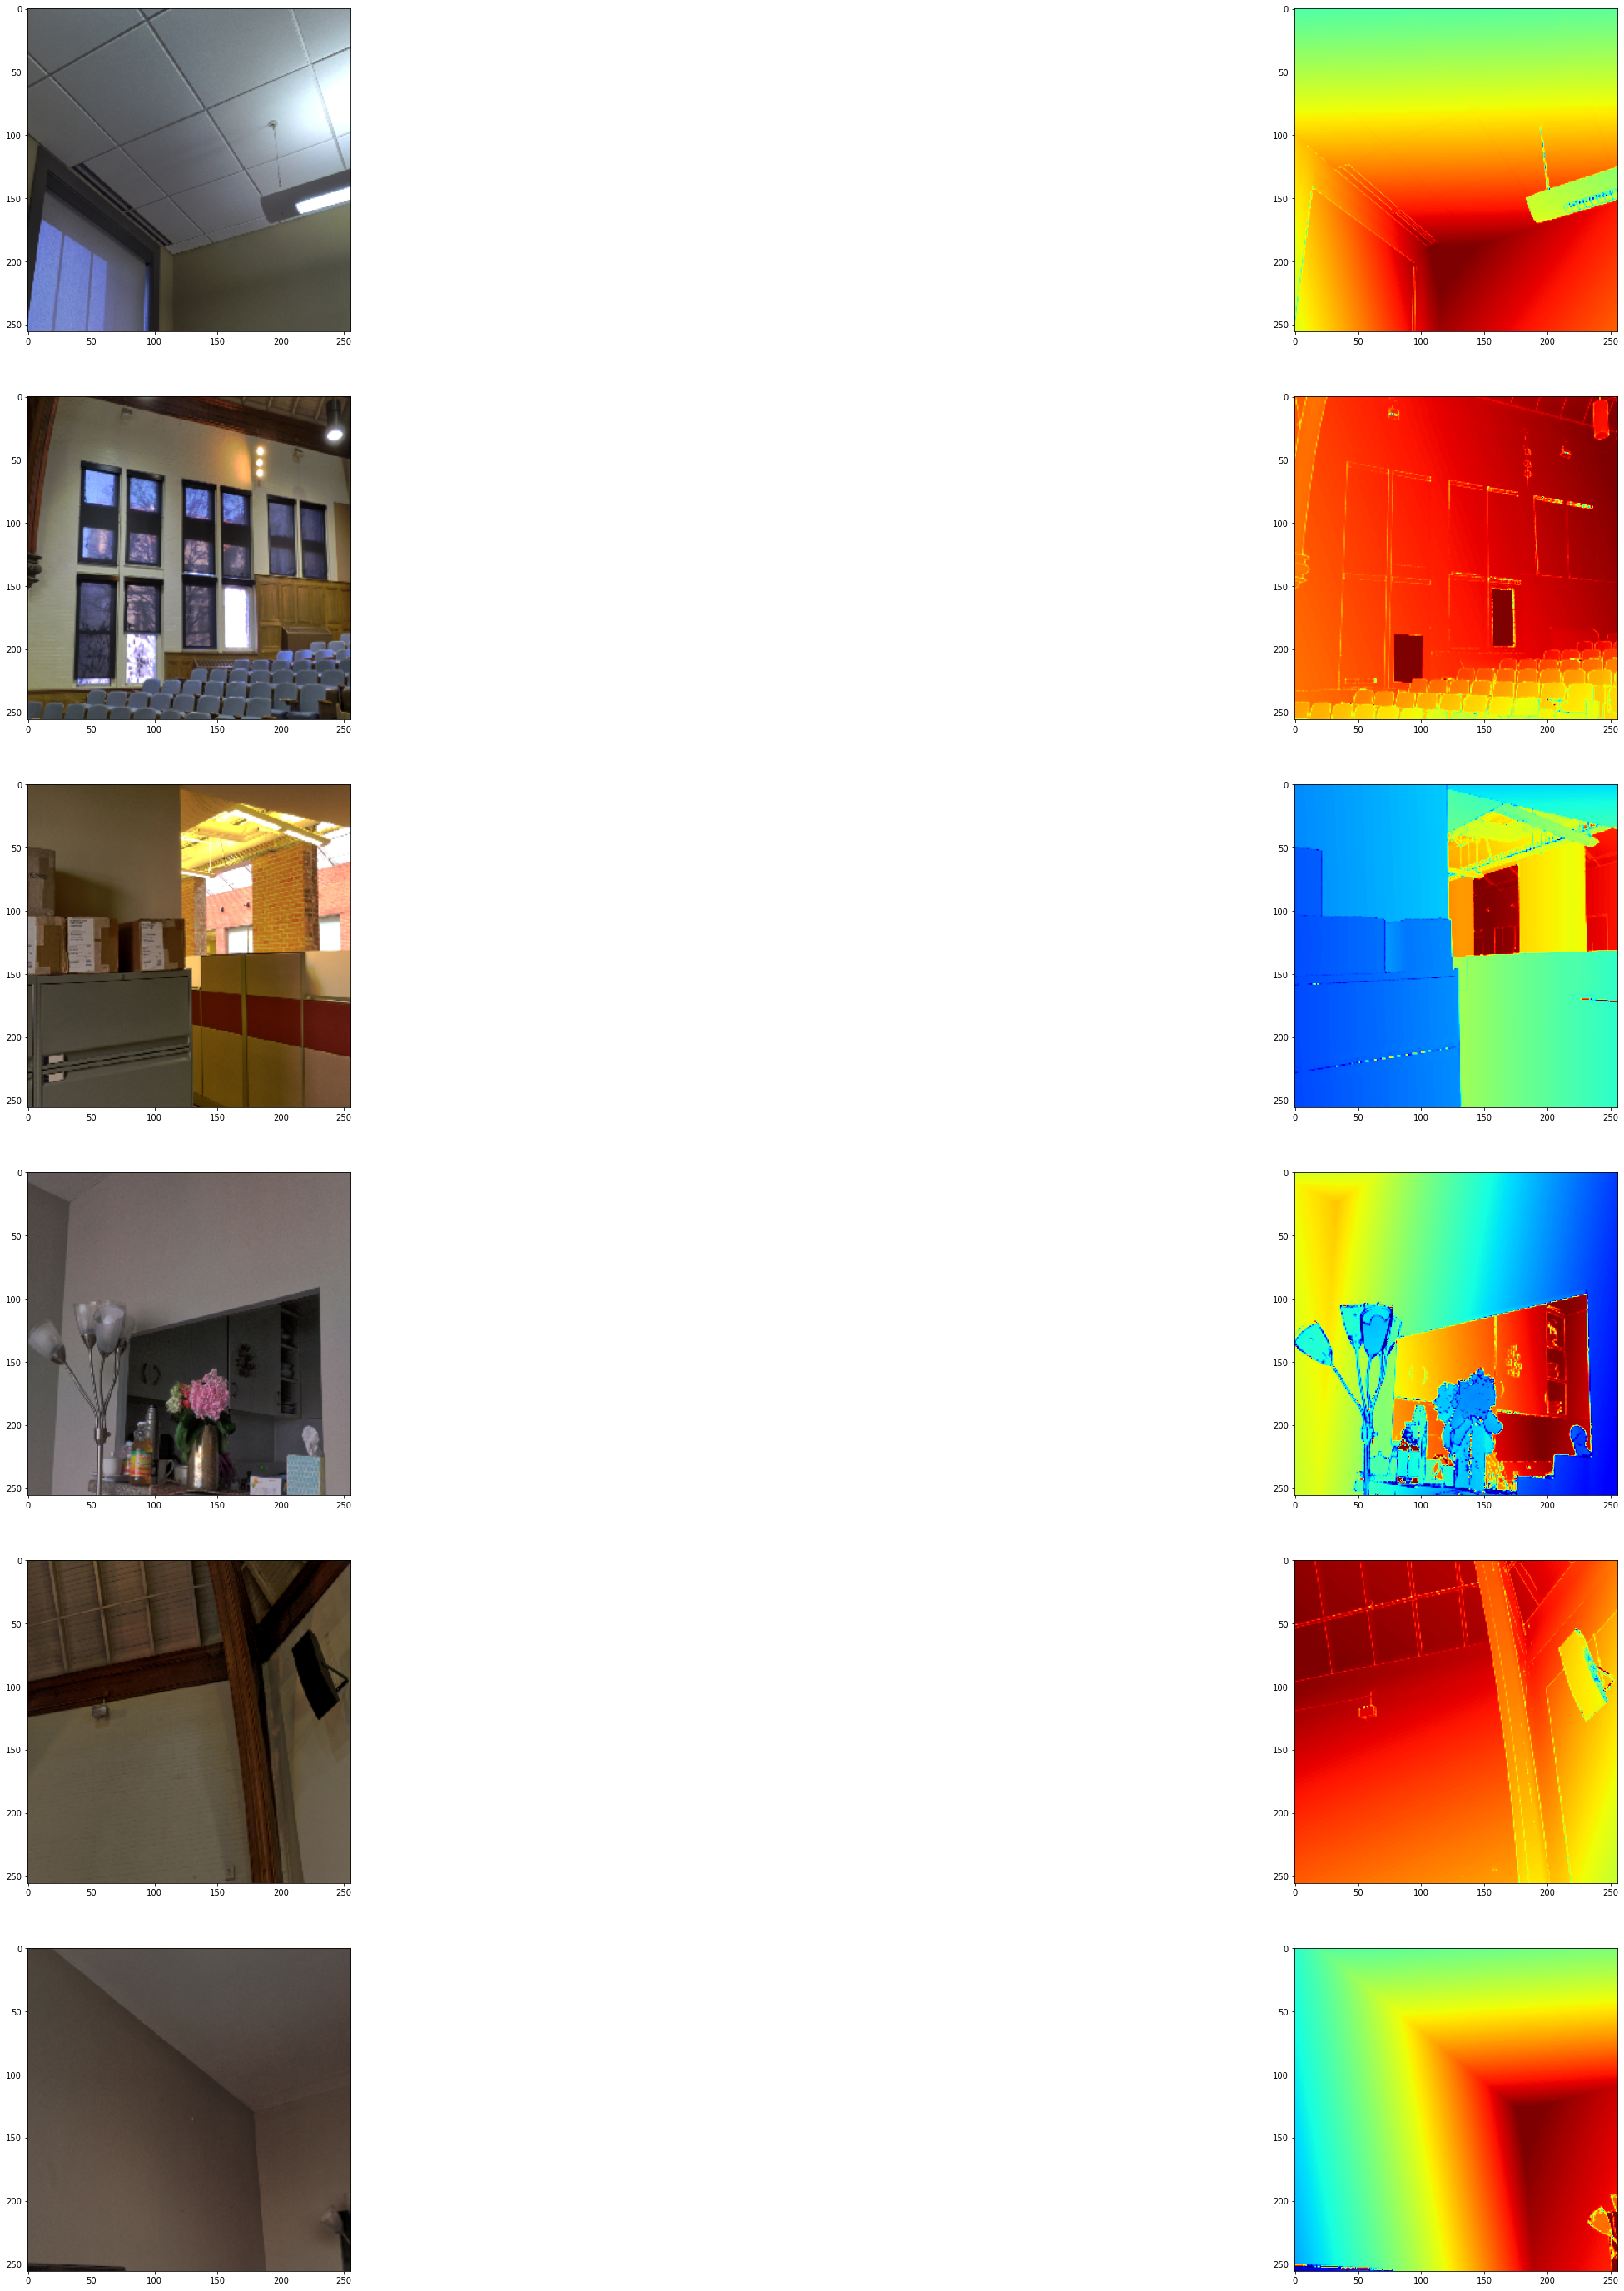

In [5]:
def visualize_depth_map(samples, test=False, model=None):
    input, target = samples
    cmap = plt.cm.jet
    cmap.set_bad(color="black")

    if test:
        pred = model.predict(input)
        fig, ax = plt.subplots(6, 3, figsize=(50, 50))
        for i in range(6):
            ax[i, 0].imshow((input[i].squeeze()))
            ax[i, 1].imshow((target[i].squeeze()), cmap=cmap)
            ax[i, 2].imshow((pred[i].squeeze()), cmap=cmap)

    else:
        fig, ax = plt.subplots(6, 2, figsize=(50, 50))
        for i in range(6):
            ax[i, 0].imshow((input[i].squeeze()))
            ax[i, 1].imshow((target[i].squeeze()), cmap=cmap)


visualize_samples = next(
    iter(DataGenerator(data=df, batch_size=6, dim=(HEIGHT, WIDTH)))
)
visualize_depth_map(visualize_samples)

In [6]:

class DownscaleBlock(layers.Layer):
    def __init__(
        self, filters, kernel_size=(3, 3), padding="same", strides=1, **kwargs
    ):
        super().__init__(**kwargs)
        self.convA = layers.Conv2D(filters, kernel_size, strides, padding)
        self.convB = layers.Conv2D(filters, kernel_size, strides, padding)
        self.reluA = layers.LeakyReLU(alpha=0.2)
        self.reluB = layers.LeakyReLU(alpha=0.2)
        self.bn2a = tf.keras.layers.BatchNormalization()
        self.bn2b = tf.keras.layers.BatchNormalization()

        self.pool = layers.MaxPool2D((2, 2), (2, 2))

    def call(self, input_tensor):
        d = self.convA(input_tensor)
        x = self.bn2a(d)
        x = self.reluA(x)

        x = self.convB(x)
        x = self.bn2b(x)
        x = self.reluB(x)

        x += d
        p = self.pool(x)
        return x, p


class UpscaleBlock(layers.Layer):
    def __init__(
        self, filters, kernel_size=(3, 3), padding="same", strides=1, **kwargs
    ):
        super().__init__(**kwargs)
        self.us = layers.UpSampling2D((2, 2))
        self.convA = layers.Conv2D(filters, kernel_size, strides, padding)
        self.convB = layers.Conv2D(filters, kernel_size, strides, padding)
        self.reluA = layers.LeakyReLU(alpha=0.2)
        self.reluB = layers.LeakyReLU(alpha=0.2)
        self.bn2a = tf.keras.layers.BatchNormalization()
        self.bn2b = tf.keras.layers.BatchNormalization()
        self.conc = layers.Concatenate()

    def call(self, x, skip):
        x = self.us(x)
        concat = self.conc([x, skip])
        x = self.convA(concat)
        x = self.bn2a(x)
        x = self.reluA(x)

        x = self.convB(x)
        x = self.bn2b(x)
        x = self.reluB(x)

        return x


class BottleNeckBlock(layers.Layer):
    def __init__(
        self, filters, kernel_size=(3, 3), padding="same", strides=1, **kwargs
    ):
        super().__init__(**kwargs)
        self.convA = layers.Conv2D(filters, kernel_size, strides, padding)
        self.convB = layers.Conv2D(filters, kernel_size, strides, padding)
        self.reluA = layers.LeakyReLU(alpha=0.2)
        self.reluB = layers.LeakyReLU(alpha=0.2)

    def call(self, x):
        x = self.convA(x)
        x = self.reluA(x)
        x = self.convB(x)
        x = self.reluB(x)
        return x


In [7]:

class DepthEstimationModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.ssim_loss_weight = 0.85
        self.l1_loss_weight = 0.1
        self.edge_loss_weight = 0.9
        self.loss_metric = tf.keras.metrics.Mean(name="loss")
        f = [16, 32, 64, 128, 256]
        self.downscale_blocks = [
            DownscaleBlock(f[0], input_shape=(HEIGHT, WIDTH, 3)), 
            DownscaleBlock(f[1]),
            DownscaleBlock(f[2]),
            DownscaleBlock(f[3]),
        ]
        self.bottle_neck_block = BottleNeckBlock(f[4])
        self.upscale_blocks = [
            UpscaleBlock(f[3]),
            UpscaleBlock(f[2]),
            UpscaleBlock(f[1]),
            UpscaleBlock(f[0]),
        ]
        self.conv_layer = layers.Conv2D(1, (1, 1), padding="same", activation="tanh")

    def calculate_loss(self, target, pred):
        # Edges
        dy_true, dx_true = tf.image.image_gradients(target)
        dy_pred, dx_pred = tf.image.image_gradients(pred)
        weights_x = tf.exp(tf.reduce_mean(tf.abs(dx_true)))
        weights_y = tf.exp(tf.reduce_mean(tf.abs(dy_true)))

        # Depth smoothness
        smoothness_x = dx_pred * weights_x
        smoothness_y = dy_pred * weights_y
        
#         print("smoothness_x:", smoothness_x)
#         print("smoothness_y:", smoothness_y)

#         depth_smoothness_loss = tf.reduce_mean(abs(smoothness_x)) + tf.reduce_mean(
#             abs(smoothness_y)
#         )
        smoothness_x = tf.cast(smoothness_x, tf.float32)
        smoothness_y = tf.cast(smoothness_y, tf.float32)
        depth_smoothness_loss = tf.reduce_mean(tf.abs(smoothness_x)) + tf.reduce_mean(tf.abs(smoothness_y))

        # Structural similarity (SSIM) index
        ssim_loss = tf.reduce_mean(
            1
            - tf.image.ssim(
                target, pred, max_val=WIDTH, filter_size=7, k1=0.01 ** 2, k2=0.03 ** 2
            )
        )
        # Point-wise depth
        l1_loss = tf.reduce_mean(tf.abs(target - pred))

        loss = (
            (self.ssim_loss_weight * ssim_loss)
            + (self.l1_loss_weight * l1_loss)
            + (self.edge_loss_weight * depth_smoothness_loss)
        )

        return loss

    @property
    def metrics(self):
        return [self.loss_metric]

    def train_step(self, batch_data):
        input, target = batch_data
        with tf.GradientTape() as tape:
            pred = self(input, training=True)
            loss = self.calculate_loss(target, pred)

        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        self.loss_metric.update_state(loss)
        return {
            "loss": self.loss_metric.result(),
        }

    def test_step(self, batch_data):
        input, target = batch_data

        pred = self(input, training=False)
        loss = self.calculate_loss(target, pred)

        self.loss_metric.update_state(loss)
        return {
            "loss": self.loss_metric.result(),
        }

    def call(self, x):
        c1, p1 = self.downscale_blocks[0](x)
        c2, p2 = self.downscale_blocks[1](p1)
        c3, p3 = self.downscale_blocks[2](p2)
        c4, p4 = self.downscale_blocks[3](p3)

        bn = self.bottle_neck_block(p4)

        u1 = self.upscale_blocks[0](bn, c4)
        u2 = self.upscale_blocks[1](u1, c3)
        u3 = self.upscale_blocks[2](u2, c2)
        u4 = self.upscale_blocks[3](u3, c1)

        return self.conv_layer(u4)


## Model training

In [8]:
# Hàm train_model
def train_model(df, epochs=EPOCHS, batch_size=BATCH_SIZE, lr=LR, height=HEIGHT, width=WIDTH):
    # Khởi tạo mô hình và bộ tối ưu hóa
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=lr,
        amsgrad=False,
    )
    model = DepthEstimationModel()
    # Define the loss function - Sử dụng SSIM, L1-loss, Depth Smoothness loss
    model.compile(optimizer, loss=model.calculate_loss)

    # Tạo dữ liệu huấn luyện và kiểm tra
    train_loader = DataGenerator(
        data=df[:260].reset_index(drop="true"), batch_size=batch_size, dim=(height, width)
    )
    validation_loader = DataGenerator(
        data=df[260:].reset_index(drop="true"), batch_size=batch_size, dim=(height, width)
    )

    # Huấn luyện mô hình
    history = model.fit(
        train_loader,
        epochs=epochs,
        validation_data=validation_loader,
    )
    return model, history

In [9]:
# ---  Hàm predict_depth_map ---
def predict_depth_map(img, model, HEIGHT, WIDTH):
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.expand_dims(img, axis=0)
    img = tf.image.resize(img, (HEIGHT, WIDTH))
    depth_map = model.predict(img)
    depth_map = depth_map.squeeze()
    return depth_map

In [10]:
# Huấn luyện mô hình
model, history = train_model(df)

# Lưu mô hình
model.save('depth_estimation_model', save_format='tf') 

Epoch 1/30
33/33 [==============================] - 44s 1s/step - loss: 0.8967 - val_loss: 0.9815
Epoch 2/30
33/33 [==============================] - 12s 356ms/step - loss: 0.5881 - val_loss: 1.0055
Epoch 3/30
33/33 [==============================] - 11s 333ms/step - loss: 0.4556 - val_loss: 0.4618
Epoch 4/30
33/33 [==============================] - 11s 337ms/step - loss: 0.3937 - val_loss: 0.4497
Epoch 5/30
33/33 [==============================] - 10s 301ms/step - loss: 0.3809 - val_loss: 0.4436
Epoch 6/30
33/33 [==============================] - 9s 277ms/step - loss: 0.3506 - val_loss: 0.3974
Epoch 7/30
33/33 [==============================] - 9s 278ms/step - loss: 0.3178 - val_loss: 0.3341
Epoch 8/30
33/33 [==============================] - 9s 280ms/step - loss: 0.3058 - val_loss: 0.4092
Epoch 9/30
33/33 [==============================] - 9s 285ms/step - loss: 0.2909 - val_loss: 0.2690
Epoch 10/30
33/33 [==============================] - 9s 281ms/step - loss: 0.2933 - val_loss: 0.25

In [11]:
print(model.summary())

Model: "depth_estimation_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
downscale_block (DownscaleBl multiple                  2896      
_________________________________________________________________
downscale_block_1 (Downscale multiple                  14144     
_________________________________________________________________
downscale_block_2 (Downscale multiple                  55936     
_________________________________________________________________
downscale_block_3 (Downscale multiple                  222464    
_________________________________________________________________
bottle_neck_block (BottleNec multiple                  885248    
_________________________________________________________________
upscale_block (UpscaleBlock) multiple                  591104    
_________________________________________________________________
upscale_block_1 (UpscaleBloc multiple       

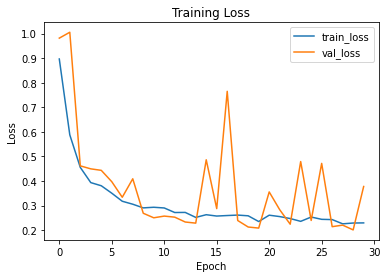

In [12]:
# Vẽ biểu đồ mất mát
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss')
plt.show()

In [13]:
# Load mô hình đã huấn luyện 
model = tf.keras.models.load_model(
    'depth_estimation_model', 
    custom_objects={'calculate_loss': DepthEstimationModel.calculate_loss}
)

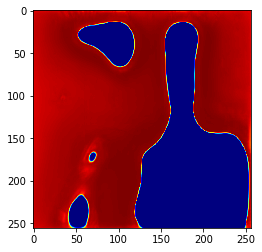

In [14]:
# img_path = '/kaggle/input/monocular-depth-estimation/val/indoors/scene_00019/scan_00183/00019_00183_indoors_000_010.png'
img_path = '/kaggle/input/image2-kitti/0000000478.png'


img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

depth_map = predict_depth_map(img, model, HEIGHT, WIDTH)

plt.imshow(depth_map, cmap='jet')
plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("jet").copy()
  after removing the cwd from sys.path.


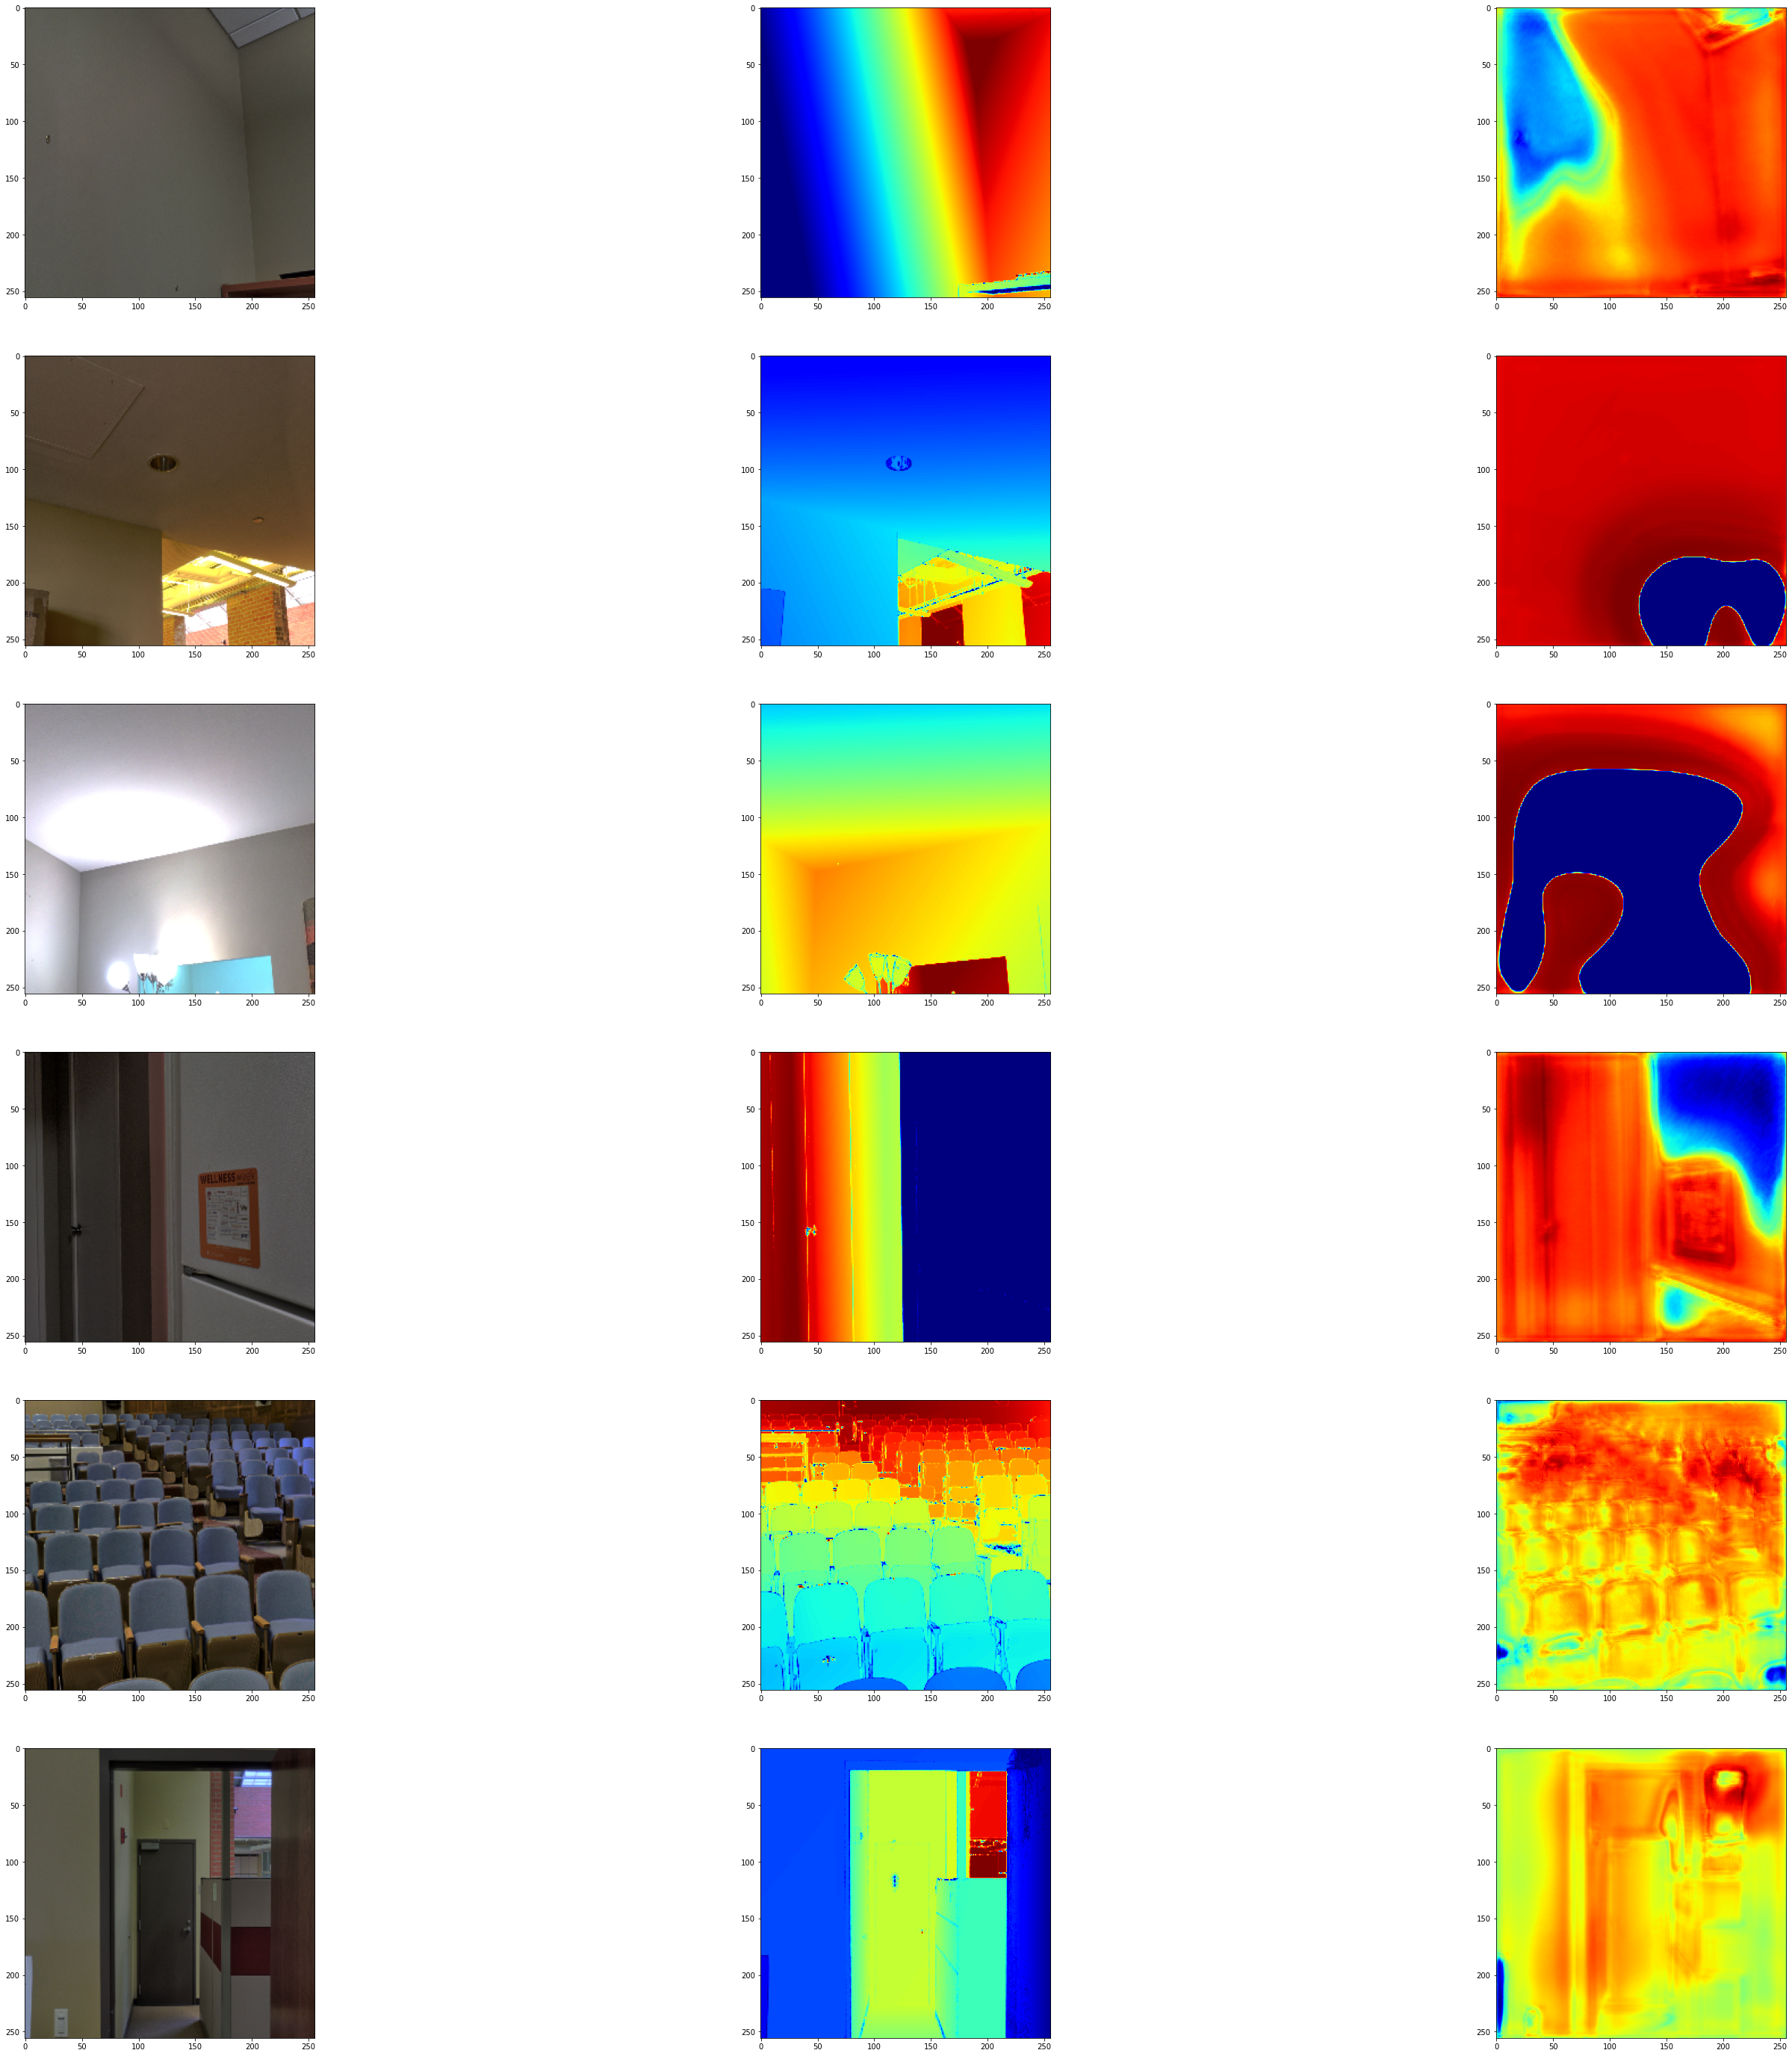

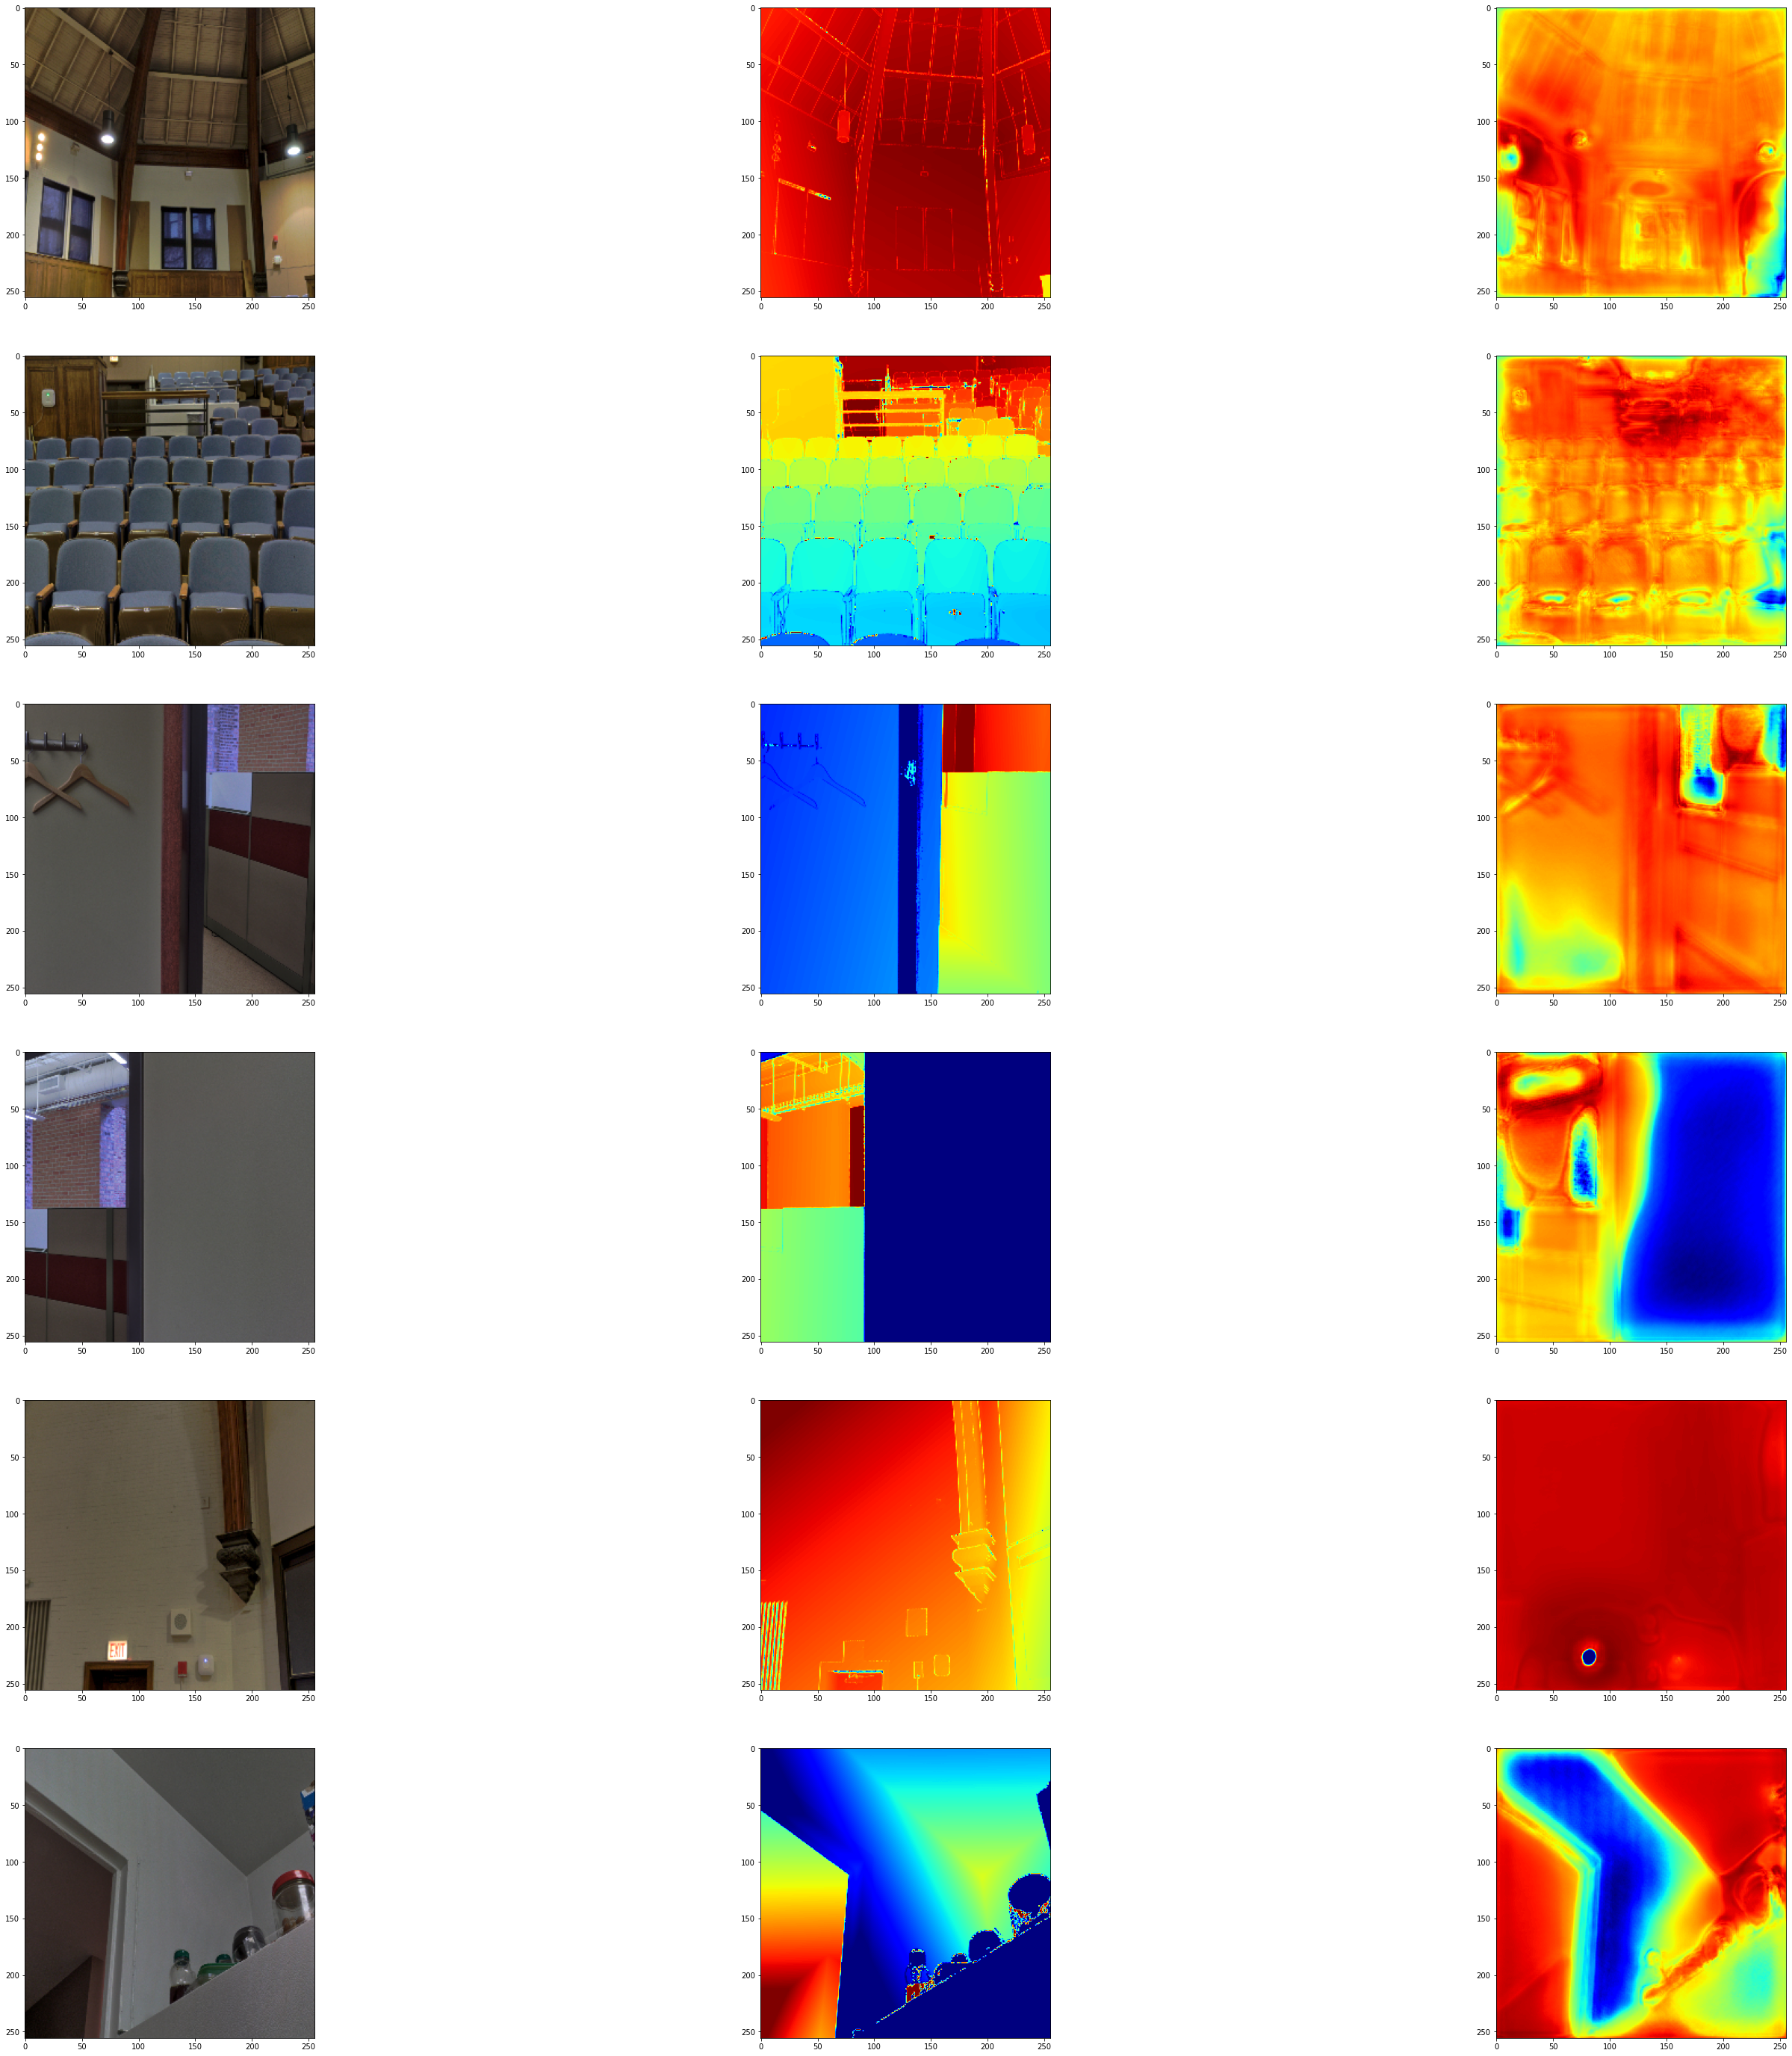

In [15]:
test_loader = next(
    iter(
        DataGenerator(
            data=df[265:].reset_index(drop="true"), batch_size=6, dim=(HEIGHT, WIDTH)
        )
    )
)
visualize_depth_map(test_loader, test=True, model=model)

test_loader = next(
    iter(
        DataGenerator(
            data=df[300:].reset_index(drop="true"), batch_size=6, dim=(HEIGHT, WIDTH)
        )
    )
)
visualize_depth_map(test_loader, test=True, model=model)

In [16]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 616.7/616.7 KB 3.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 MB 18.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 KB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 614.9/614.9 KB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 614.4/614.4 KB 39.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 606.9/606.9 KB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 606.2/606.2 KB 39.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 605.5/605.5 KB 36.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 605.6/605.6 KB 29.2 MB/s eta 0:00:00
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.63.0
    Uninstalling tqdm-4.63.0:
      Successfully uninstalled tqdm-4.63.0
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.5.4.60
    Uninsta

In [17]:
from ultralytics import YOLO

object_model = YOLO("/model/yolov8s.pt")  

  0%|          | 0.00/21.5M [00:00<?, ?B/s]

In [18]:
import glob

# # Danh sách các ảnh trong video
left_video = sorted(glob.glob("/data/video - kitti/video - kitti/image_02/data/*.png"))
# left_video = '/kaggle/input/d/ngcynphm/input-data/video - kitti/image_02/data/0000000459.png'

In [19]:
if len(left_video) == 0:
    print("Không tìm thấy ảnh trong thư mục")
    exit()

In [20]:
left_img = cv2.imread(left_video[0])
print(type(left_video), len(left_video), left_img.shape)

<class 'list'> 481 (375, 1242, 3)


In [21]:
depth_min = np.min(depth_map)
depth_max = np.max(depth_map)

print(f"min: {depth_min}")
print(f"max: {depth_max}")

min: -1.0
max: 0.9974547624588013


In [24]:
video_out = []  
for i in range(len(left_video)):
    left_im = cv2.imread(left_video[i])
    left_img = cv2.cvtColor(left_im, cv2.COLOR_BGR2RGB)

    # Predict the depth map (256x256)
    depth_map = predict_depth_map(left_img, model, HEIGHT, WIDTH)

    # Resize depth map to the original frame size (1242x375)
    depth_map_resized = cv2.resize(depth_map, (1242, 375))

    # Detect objects
    results = object_model.predict(source=left_video[i])
    boxes = results[0].boxes.xyxy.cpu().numpy()

    # Draw bounding boxes and print depth information (on the original image)
    for box in boxes:
        x1, y1, x2, y2 = box.tolist()

        # Calculate depth and handle NaN values (using the resized depth map)
        depth_region = depth_map_resized[int(y1):int(y2), int(x1):int(x2)]
        
        depth_min = np.min(depth_region)
        depth_mean = np.mean(depth_region)
        depth_median = np.median(depth_region)

        cv2.rectangle(left_img, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
        cv2.putText(left_img, f"Min: {depth_min:.2f}m", (int(x1), int(y1 - 10)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        cv2.putText(left_img, f"Mean: {depth_mean:.2f}m", (int(x1), int(y1 - 25)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        cv2.putText(left_img, f"Median: {depth_median:.2f}m", (int(x1), int(y1 - 40)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)  
    
    video_out.append(left_img)

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('out6.avi', fourcc, 24, (1242, 375)) 
for i in range(len(video_out)):
    out.write(cv2.cvtColor(video_out[i], cv2.COLOR_BGR2RGB))
out.release()
print('Finish')


image 1/1 /kaggle/input/kitti-video/video - kitti/video - kitti/image_02/data/0000000000.png: 224x640 1 car, 12.0ms
Speed: 1.3ms preprocess, 12.0ms inference, 1.4ms postprocess per image at shape (1, 3, 224, 640)

image 1/1 /kaggle/input/kitti-video/video - kitti/video - kitti/image_02/data/0000000001.png: 224x640 (no detections), 11.4ms
Speed: 1.2ms preprocess, 11.4ms inference, 0.7ms postprocess per image at shape (1, 3, 224, 640)

image 1/1 /kaggle/input/kitti-video/video - kitti/video - kitti/image_02/data/0000000002.png: 224x640 1 car, 14.0ms
Speed: 1.8ms preprocess, 14.0ms inference, 1.4ms postprocess per image at shape (1, 3, 224, 640)

image 1/1 /kaggle/input/kitti-video/video - kitti/video - kitti/image_02/data/0000000003.png: 224x640 (no detections), 11.5ms
Speed: 1.2ms preprocess, 11.5ms inference, 0.8ms postprocess per image at shape (1, 3, 224, 640)

image 1/1 /kaggle/input/kitti-video/video - kitti/video - kitti/image_02/data/0000000004.png: 224x640 1 car, 11.8ms
Speed: 

Finish
